In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import librosa

import IPython.display as ipd


np.random.seed(42) # Setting a random seed now for reproducibility 

In [2]:
tracks = pd.read_csv('../data/tracks_meta.csv', index_col = 0)

# pre-computed melspectograms saved as numpy files
data = [(idx, np.load('D:/GA-DSI/capstone-data/audio/' + str(idx) + '.npy')) for idx in tracks.index]
raw_data = pd.DataFrame(data, columns = ['idx', 'audio']).set_index('idx')

df = pd.merge(
    tracks,
    raw_data,
    how = 'inner',
    left_index = True,
    right_index = True
)

In [3]:
# clearing out redundant data here to not use too much memory
del tracks 
del data
del raw_data

In [4]:
df.head() # ensuring merge looks okay

title                             name  \
track_id                                                        
2                       Food                             AWOL   
5                 This World                             AWOL   
10                   Freeway                        Kurt Vile   
140       Queen Of The Wires  Alec K. Redfearn & the Eyesores   
141                     Ohio  Alec K. Redfearn & the Eyesores   

                          album genre_top     split  \
track_id                                              
2          AWOL - A Way Of Life   Hip-Hop  training   
5          AWOL - A Way Of Life   Hip-Hop  training   
10            Constant Hitmaker       Pop  training   
140              The Blind Spot      Folk  training   
141       Every Man For Himself      Folk  training   

                                                      audio  
track_id                                                     
2         [[-33.642303, -34.974335, -37.508316, -26.9131...  
5         [[-13.714327, -6.389556, -4.964631, -8.284372,...  
10        [[-34.332733, -25.239313, -16.618084, -15.5469...  
140       [[-52.287685, -52.287685, -52.287685, -52.2876...  
141       [[-46.01184, -46.01184, -46.01184, -46.01184, ...

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7994 entries, 2 to 155066
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      7994 non-null   object
 1   name       7994 non-null   object
 2   album      7994 non-null   object
 3   genre_top  7994 non-null   object
 4   split      7994 non-null   object
 5   audio      7994 non-null   object
dtypes: object(6)
memory usage: 695.2+ KB


Let's ensure genre and split distributions look okay before we worry about EDA.

In [6]:
df['genre_top'].value_counts()

Pop              1000
Folk             1000
International    1000
Instrumental     1000
Experimental      999
Rock              999
Electronic        999
Hip-Hop           997
Name: genre_top, dtype: int64

In [7]:
df['split'].value_counts()

training      6394
validation     800
test           800
Name: split, dtype: int64

We're missing 6 songs due to incomplete data which is fine, they're all in the training set so no need to stress too much here. Hip-Hop has the most missing tracks but still, it's only 3 songs total so we aren't going to be worried about imbalanced data at all moving forward.

Out of curiosity, who are our top 5 artists?

In [8]:
df['name'].value_counts().sort_values(ascending = False).head() # That's quite a lot of representation so let's check that out real quick

Blue Dot Sessions    208
Big Blood             91
The Impossebulls      68
Squire Tuck           56
Kellee Maize          55
Name: name, dtype: int64

In [9]:
df[df['name'] == 'Blue Dot Sessions'][['genre_top', 'split']].value_counts() # They're all in the training set and comprise ~25% of our instrumental training set

genre_top     split   
Instrumental  training    208
dtype: int64

This might end up being a notable shortcoming for our model. That is quite a lot of representation for one artist, especially given they're only in the training set. We will need to assess what effect if any this has on our model later but we will leave this as is otherwise. The data was split by the researchers who gathered it so we will proceed as is and note if this results in any odd behavior later on.

Since they are the most prominent artist let's take a look at one of their songs:

In [10]:
example_song = df[df['name'] == 'Blue Dot Sessions'].sample(1)
example_song

title               name            album     genre_top     split  \
track_id                                                                     
127661    Krok  Blue Dot Sessions  Simple Machines  Instrumental  training   

                                                      audio  
track_id                                                     
127661    [[6.088013, 10.096022, 8.496839, 6.8959575, 7....

In [11]:
# Getting the path is a bit complicated due to the folder structure for the FMA data
# Each song's index is composed of up to 6 digits where the first 3 tell us the folder
# and the whole index with .mp3 appended on is the filename in that folder.
# However, the our indexes are integers so '000002' became 2. Padding and splicing
# solves this issue and this function allows just makes the next line cleaner.
def get_path(index):
    PATH = "D:/GA-DSI/capstone-data/fma_small/"
    padded_index = '0'*6 + str(index) + '.mp3'
    path = PATH + padded_index[-10:-7] + '/' + padded_index[-10:]

    return path

In [12]:
# Let's take a listen
song, sr = librosa.load(get_path(example_song.index[0]))



# Librosa and jupyter actually let us listen directly to the song which is fun
ipd.Audio(song, rate = sr)

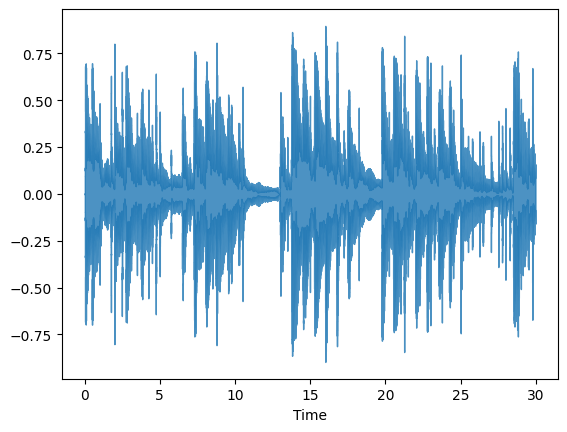

In [13]:
# Let's take an actual look at our song now
librosa.display.waveshow(song, sr = sr, alpha = 0.8);

This is more or less the standard way that a layperson would look at audio data. The issue here is that this more or less tells us that there's some sound at this time and that's nice but not very helpful to understand the song. Luckily, linear algebra's got our back and we can turn this data into something a bit more helpful to us. The standard process for visualizing audio data is called a Fourier Transform (more specifically a Fast-Fourier Transform) and then computing a Mel Spectogram which essentially rescales our data to better represent how it is heard by human beings.

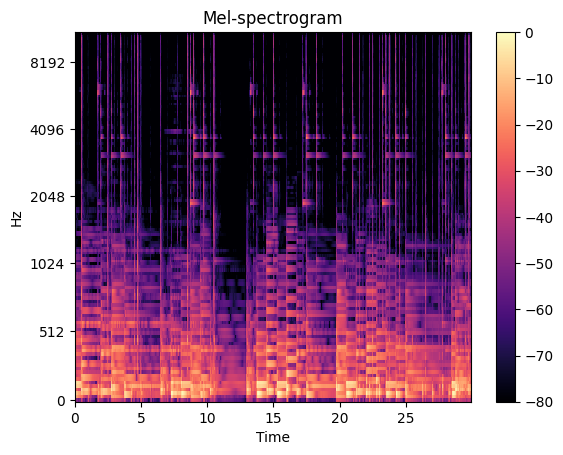

In [14]:
# Let's take a (better) look at our song

# Ref = np.max makes the plot easier to read compared to the default of 1
# the data we will feed into our model is referenced to 1 in the hope that values
# centered around 0 will give us slightly more accurate results.
instr_mel = librosa.power_to_db(librosa.feature.melspectrogram(y = song, sr = sr), ref = np.max)

librosa.display.specshow(instr_mel, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title("Mel-spectrogram");

It's easiest to think of this plot as a heatmap where the brighter patches refer to louder sounds at that frequency at that time. There isn't too much we can say just from this graph however, since this graph is just one song with no real point of comparison. Let's compare to a song in a very different genre because that will give us some insight into how easy our model's job is going to be.

In [15]:
example_song = df[df['genre_top'] == 'Electronic'].sample(1) # choosing electronic for maximum visual difference
song, sr = librosa.load(get_path(example_song.index[0]))

# We can listen to it real quick as well
ipd.Audio(song, rate = sr)

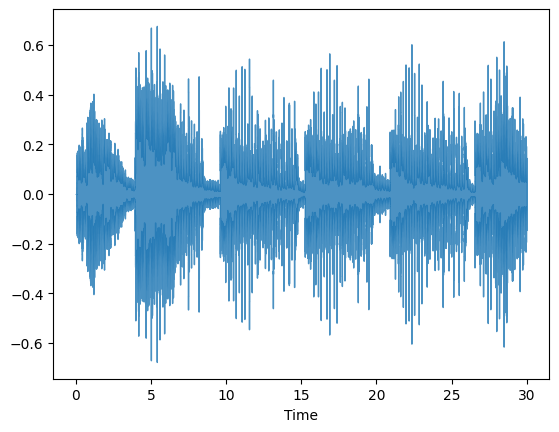

In [16]:
# Again, the waveplot doesn't say much but it is visually quite different
librosa.display.waveshow(song, sr = sr, alpha = 0.8); 

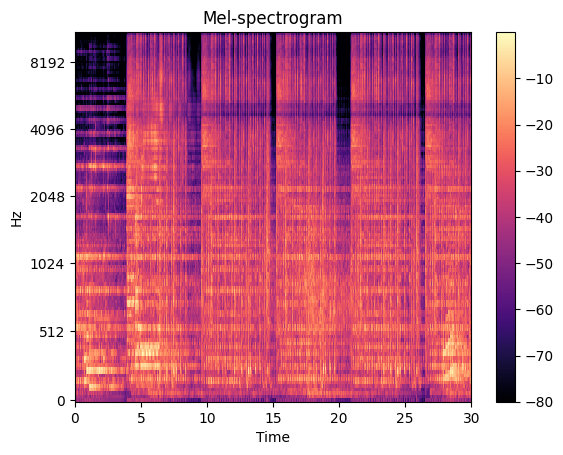

In [17]:
elec_mel = librosa.power_to_db(librosa.feature.melspectrogram(y = song, sr = sr), ref = np.max)

librosa.display.specshow(elec_mel, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title("Mel-spectrogram");

This is quite different so let's look at them side by side.

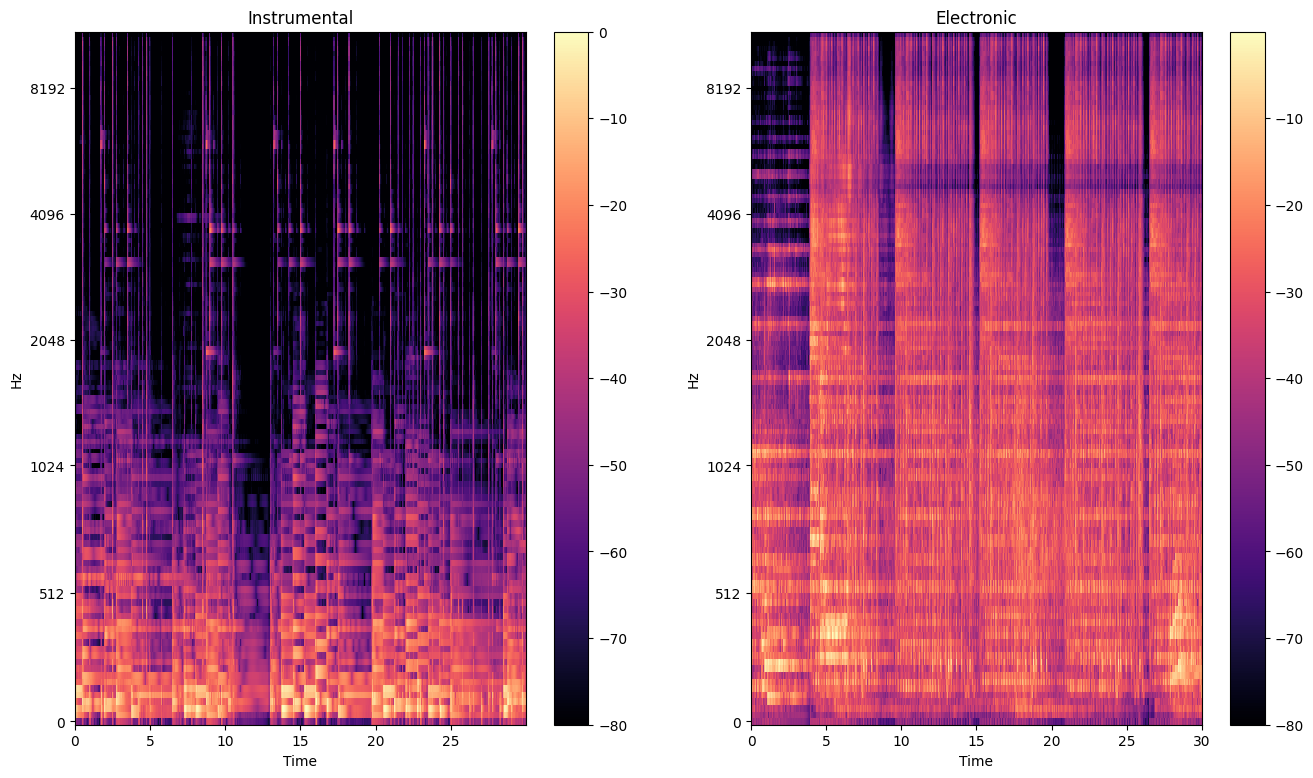

In [18]:
fig, ax = plt.subplots(ncols = 2, figsize = (16, 9))

inst_spec = librosa.display.specshow(instr_mel, x_axis='time', y_axis='mel', ax = ax[0])
plt.colorbar(inst_spec, ax = ax[0])
ax[0].set_title("Instrumental")

edm_spec = librosa.display.specshow(elec_mel, x_axis='time', y_axis='mel', ax = ax[1])
plt.colorbar(edm_spec, ax = ax[1])
ax[1].set_title('Electronic');

The waveplots from earlier did look a bit different but once we look at the frequencies directly we see that these songs look nothing alike which is quite interesting. The electronic song uses a much wider range of frequencies much more than the instrumental one which mostly stays in the bass to mid-bass ranges with some mid and high frequencies sporadically. By comparison, the electronic song is every all at once all the time. Obviously, this is an extreme case but it is a good sign our model might have some real success.

This is about the extent of how we can explore our songs on an individual level using this data so let's instead consider some aggregate approaches.

In [22]:
genres = df['genre_top'].unique()

genre_avg = dict()

for genre in genres:
    subset_idx = df[df['genre_top'] == genre].index

    song, sr = librosa.load(get_path(subset_idx[0]))

    mel = librosa.power_to_db(librosa.feature.melspectrogram(y = song, sr = sr), ref = np.max)[ : , :1291]
    
    count = 1
    for idx in subset_idx[1:]:
        song, sr = librosa.load(get_path(idx))

        mel += librosa.power_to_db(librosa.feature.melspectrogram(y = song, sr = sr), ref = np.max)[ : , :1291] 
        count += 1

    genre_avg[genre] = mel/count

    del song
    del sr
    del mel

    

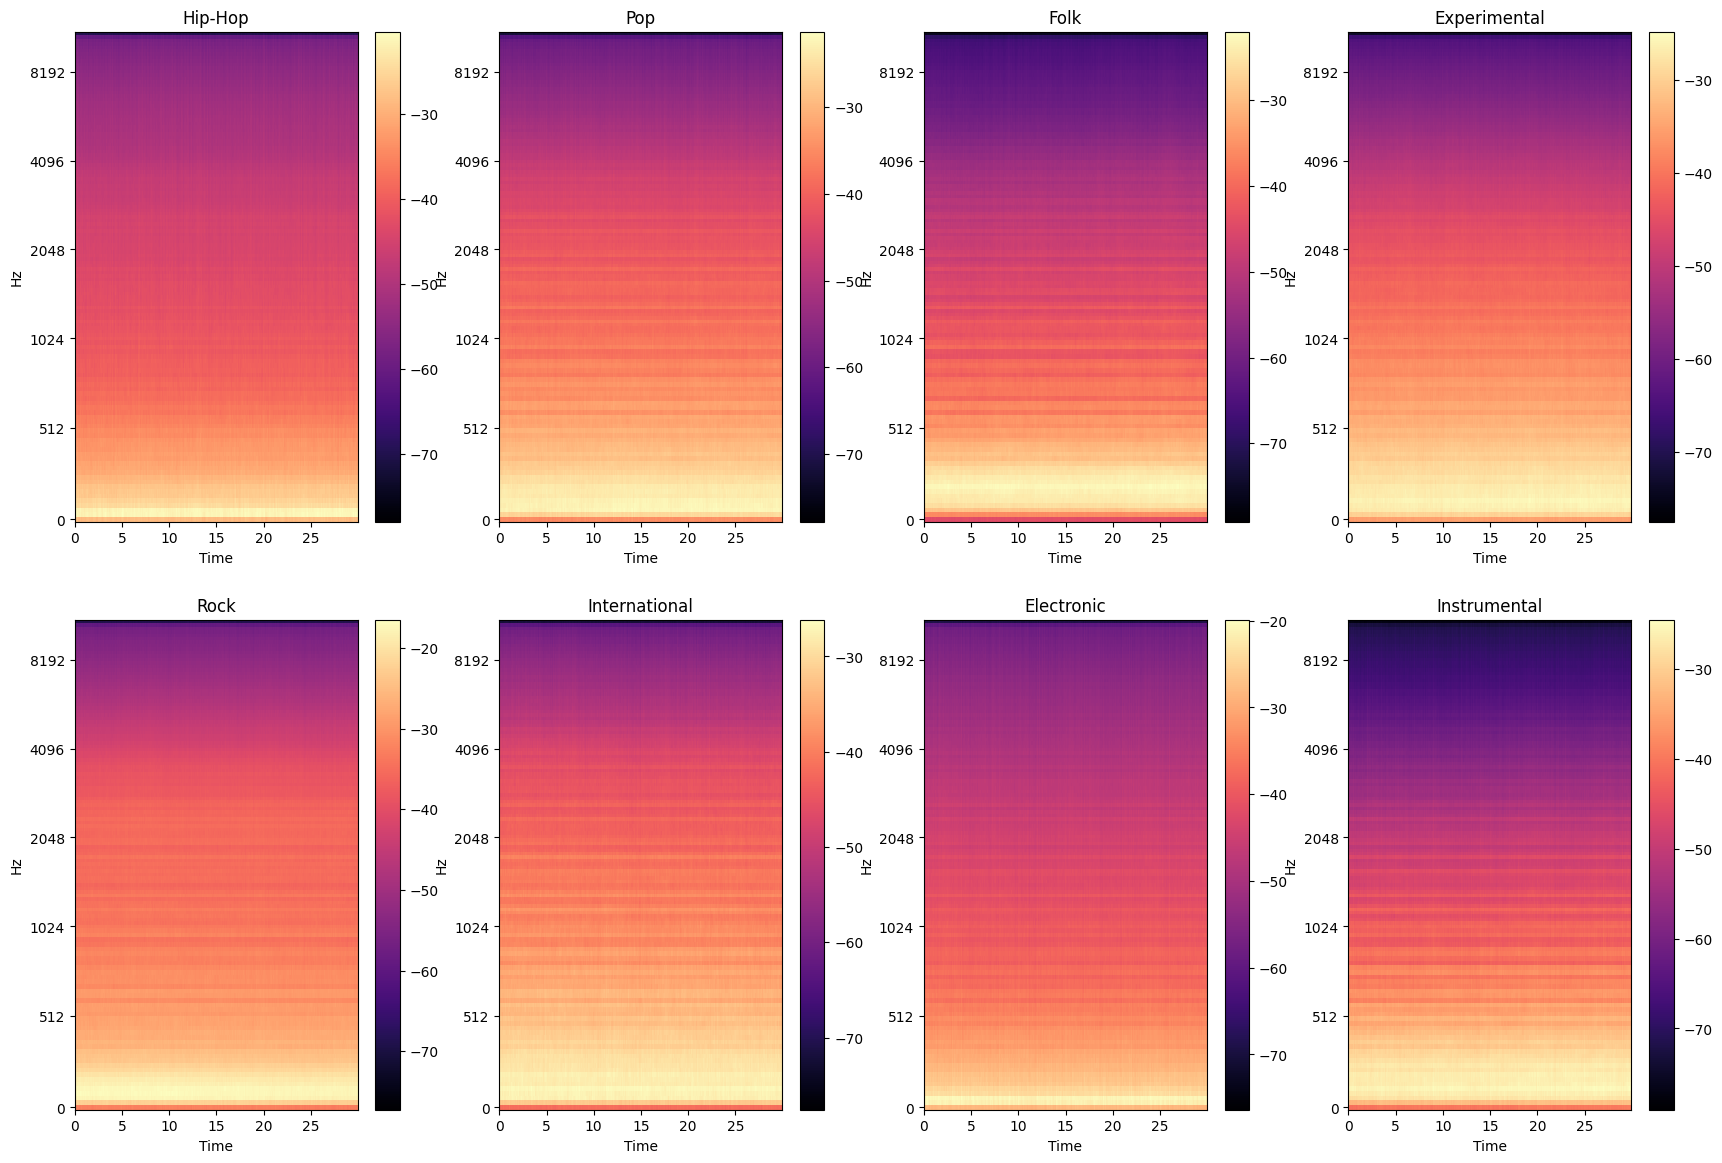

In [33]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (21, 14))

for key, axis in zip(genre_avg.keys(), ax.flatten()):
    plot = librosa.display.specshow(genre_avg[key], x_axis='time', y_axis='mel', ax = axis)
    plt.colorbar(plot, ax = axis)
    axis.set_title(key)

At first glance this is somewhere between mildly and incredibly troubling. By and large our plots look very similar but on closer glance there are some interesting differences. 